In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

from scipy.ndimage.interpolation import rotate

In [2]:
train = read_csv("data/training.csv")

In [9]:
def load(raw, cols=None, complete=True, rstate=30):    
    # Filter to a subset of colums (but always include Image)
    if cols:
        tmp = raw[list(cols) + ['Image']]
    else:
        tmp = raw
    
    # If complete=True, only include complete cases of this column subset.
    if complete:
        tmp = tmp.dropna()
    
    # Convert the Image field into a numpy array
    tmp['Image'] = tmp['Image'].apply(lambda im: np.fromstring(im, sep=' '))
    
    # Extract and scale the features (image)
    data = np.vstack(tmp['Image'].values) / 255
    data = data.astype(np.float32)
    
    # Extract and scale labels (target coordinates to between -1 and 1)
    labels = tmp[tmp.columns[:-1]].values
    labels = (labels - 48) / 48
    labels = labels.astype(np.float32)
    
    data, labels = shuffle(data, labels, random_state=rstate)  # shuffle train data
    
    return data, labels

# Convert the image vector to a square for convolution and display
def img_vec_to_square(img):
    return img.reshape(96,96)

# Plot a face with optional prediction and label dots    
def plot_face(ax, data, preds=None, labs=None):
    # Shape the pixel data into a square
    img = img_vec_to_square(data)
    # Display the image
    ax.imshow(img, cmap='gray')
    # Mark the predictions in red
    if preds is not None:
        ax.scatter(preds[0::2]*48+48, preds[1::2]*48+48, marker='.', s=10, c='r')
    # Mark the true labels in yellow
    if labs is not None:
        ax.scatter(labs[0::2]*48+48, labs[1::2]*48+48, marker='.', s=10, c='y')
    
    ax.get_yaxis().set_ticklabels([])
    ax.get_xaxis().set_ticklabels([])

In [10]:
data, labels = load(train)

//anaconda/envs/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(9216,)
(96, 96)
(96, 96)
(96, 96)


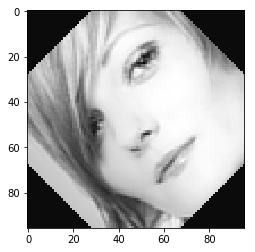

In [34]:
# face = data[1]
# face_sq = img_vec_to_square(data[1])
# face_90 = np.rot90(face_sq)
# face_45 = rotate(face_sq, angle=45, reshape=False)


# print(face.shape)
# print(face_sq.shape)
# print(face_90.shape)
# print(face_45.shape)



# face = data[1]
# face_sq = img_vec_to_square(data[1])
# face_90 = np.rot90(face_sq)
# face_45 = rotate(face_sq, angle=45, reshape=False)# plt.imshow(face_45, cmap='gray')

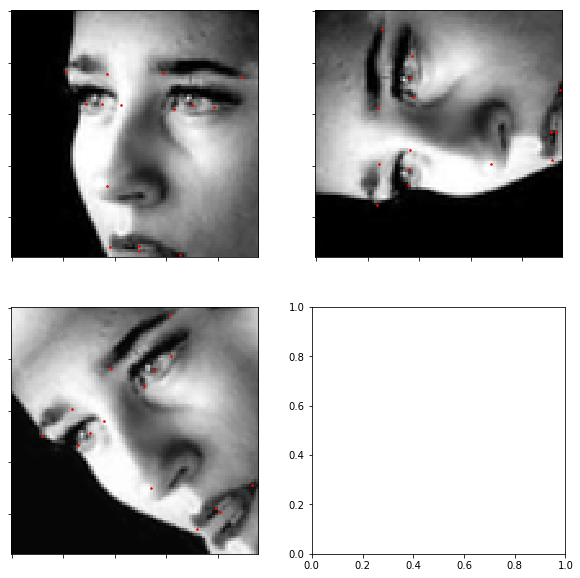

In [205]:
def rotate_points(points, angle):
    tmp = points_1d_to_2d(points)
    
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])
    
    return points_2d_to_1d(R.dot(tmp.T).T)

def points_1d_to_2d(points):
    return np.reshape(np.array(points), (-1,2))

def points_2d_to_1d(points):
    return np.reshape(np.array(points), -1)

i = 0

points = labels[i]
face = data[i]
face_sq = img_vec_to_square(face)
face_90 = np.rot90(face_sq)
face_45 = rotate(face_sq, angle=45, reshape=False, mode="reflect")

points_90 = rotate_points(points, -90)
points_45 = rotate_points(points, -45)
points_10 = rotate_points(points, -10)

fig, axarr = plt.subplots(2,2)
fig.set_figwidth(10)
fig.set_figheight(10)

plot_face(axarr[0,0], face_sq, points)
plot_face(axarr[0,1], face_90, points_90)
plot_face(axarr[1,0], face_45, points_45)

In [109]:
print(np.radians(90))
print(np.radians(45))

1.57079632679
0.785398163397


## Close to the Edge

Finding which images have points closest to the edges.

In [166]:
new_train = read_csv("data/training.csv")
all_data, all_labels = load(new_train, complete=False)

In [167]:
print(all_data.shape, all_labels.shape)

(7049, 9216) (7049, 30)


In [174]:
topmost = bottommost = leftmost = rightmost = -1
topmost_val = bottommost_val = leftmost_val = rightmost_val = 0

for i in range(0, all_labels.shape[0]):
    lab = points_1d_to_2d(all_labels[i])
    max_x_ind, max_y_ind = np.argmax(lab, axis=0)
    min_x_ind, min_y_ind = np.argmin(lab, axis=0)
    
    max_x = lab[max_x_ind, 0]
    min_x = lab[min_x_ind, 0]
    max_y = lab[max_y_ind, 1]
    min_y = lab[min_y_ind, 1]
    
    if max_y > bottommost_val:
        bottommost_val = max_y
        bottommost = i
    
    if min_y < topmost_val:
        topmost_val = min_y
        topmost = i
    
    if max_x > rightmost_val:
        rightmost_val = max_x
        rightmost = i
    
    if min_x < leftmost_val:
        leftmost_val = min_x
        leftmost = i

In [175]:
print(topmost, bottommost, leftmost, rightmost)
print(topmost_val, bottommost_val, leftmost_val, rightmost_val)
print(all_labels[topmost])

1728 3228 3239 4478
-0.780785 0.99602 -0.920287 0.963957
[ 0.39504907 -0.50347924 -0.46100378 -0.48389435  0.18523774 -0.43353963
  0.67760754 -0.45312452 -0.23999999 -0.45312452 -0.7099849  -0.43633962
  0.08130566 -0.60516226  0.68701887 -0.7807849  -0.19523774 -0.62377357
 -0.77992451 -0.72449058 -0.02019623  0.11283774  0.33022642  0.48220378
 -0.36670944  0.49157736 -0.00126038  0.38749433 -0.01073208  0.63374341]


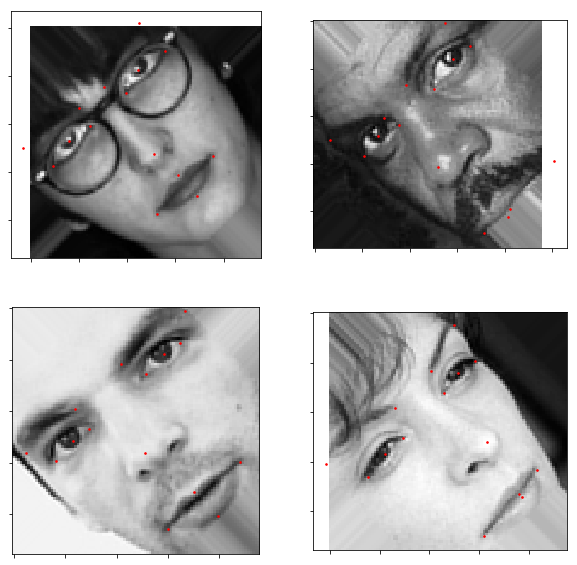

In [190]:
fig, axarr = plt.subplots(2,2)
fig.set_figwidth(10)
fig.set_figheight(10)
# rotate(face_sq, angle=45, reshape=False)  points_90 = rotate_points(points, -90)

ang = 45

plot_face(axarr[0,0], rotate(img_vec_to_square(all_data[topmost]), angle=ang, reshape=False, mode="nearest"), rotate_points(all_labels[topmost], ang*-1))
plot_face(axarr[0,1], rotate(img_vec_to_square(all_data[bottommost]), angle=ang, reshape=False, mode="nearest"), rotate_points(all_labels[bottommost], ang*-1))
plot_face(axarr[1,0], rotate(img_vec_to_square(all_data[rightmost]), angle=ang, reshape=False, mode="nearest"), rotate_points(all_labels[rightmost], ang*-1))
plot_face(axarr[1,1], rotate(img_vec_to_square(all_data[leftmost]), angle=ang, reshape=False, mode="nearest"), rotate_points(all_labels[leftmost], ang*-1))

In [191]:
print(rotate_points(all_labels[topmost], ang*-1))
print(rotate_points(all_labels[bottommost], ang*-1))
print(rotate_points(all_labels[leftmost], ang*-1))
print(rotate_points(all_labels[rightmost], ang*-1))

[-0.07667171 -0.63535546 -0.66814387 -0.01618608 -0.17557595 -0.43754167
  0.15873346 -0.79954831 -0.49011305 -0.1507018  -0.81057384  0.19349643
 -0.37042256 -0.48540612 -0.0663026  -1.037894   -0.57912846 -0.30302059
 -1.06378212  0.03919771  0.06550744  0.09406922  0.57447491  0.10746422
  0.08829495  0.60690042  0.27310864  0.27489109  0.44053554  0.45571298]
[ 0.21239144 -0.67187743 -0.44090406  0.00276469  0.04695515 -0.40771304
  0.36319644 -0.78680232 -0.25856834 -0.09418455 -0.56510728  0.17796854
 -0.19680731 -0.44459873  0.14478399 -0.986605   -0.38836417 -0.15449525
 -0.86614909  0.04315155  0.0810648   0.27735508  1.10085469  0.22563602
  0.48398094  0.85490145  0.71012926  0.64269379  0.69425243  0.71433326]
[ 0.07021258 -0.49316164 -0.5430118   0.18142897 -0.04813665 -0.32922604
  0.21486162 -0.60011429 -0.39178777  0.05124481 -0.68169955  0.38122003
 -0.1540874  -0.5095632   0.03827709 -0.90194298 -0.45793584 -0.19915688
 -1.03502924  0.26645254  0.32057214  0.08512604 

If any of the labels are > 1 or < -1, they have moved outside the boundaries of the plot.

In [192]:
print(all_labels[bottommost])

[ 0.62527251 -0.32490566 -0.31372118 -0.30981132  0.32149896 -0.25509435
  0.81317192 -0.29953459 -0.1162369  -0.24943396 -0.52543396 -0.27374843
  0.17521499 -0.45354256  0.80001283 -0.59525734 -0.1653703  -0.38385957
 -0.64297265 -0.58194715 -0.13879819  0.25344113  0.61887306  0.93797058
 -0.2622804   0.94673282  0.04768408  0.95659035 -0.01419929  0.9960205 ]


-0.634786448503 0.930421685446
[ 0.41461865 -0.31173279 -0.30711637 -0.20676182  0.27192185 -0.26045901
  0.59387651 -0.32505682 -0.15580811 -0.21814044 -0.43937991 -0.18814374
  0.14102059 -0.53365111  0.77733026 -0.59669283 -0.30767228 -0.45138112
 -0.63478645 -0.41313409 -0.16498218  0.44467231  0.51043261  0.90364357
 -0.05778929  0.93042169  0.16513396  0.88054227  0.17278014  0.92628664]
9


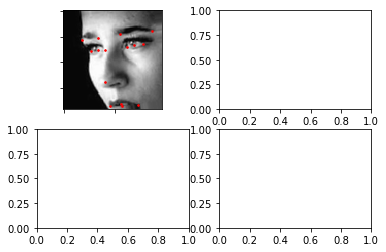

In [224]:
def random_rotate(data, labels, max_angle=15):
    angle = np.random.randint(-1*max_angle, max_angle)
    
    rot_data = rotate(img_vec_to_square(data), angle=angle, reshape=False, mode="nearest")
    rot_labels = rotate_points(labels, angle*-1)
    
    print(np.min(rot_labels), np.max(rot_labels))
    print(rot_labels)
    print(angle)
    
    if np.min(rot_labels) < -1 or np.max(rot_labels) > 1:
        return data, labels, False
    else:
        return rot_data, rot_labels, True
    
    rotated = True
    return rot_data, rot_labels, rotated

newd, newl, rot = random_rotate(data[0], labels[0])
fig, axarr = plt.subplots(2,2)
plot_face(axarr[0,0], newd, newl)